In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import nc_tools
from salishsea_tools import tidetools
%matplotlib inline

In [2]:
# read in old bathymetry
nc_filepath1 = '../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
old_bathy = nc.Dataset(nc_filepath1, 'r')
old_depth = old_bathy.variables['Bathymetry']

In [3]:
# read in old TS, this also gives the depths of the cells
nc_filepath2 = '/data/dlatorne/MEOPAR/SalishSea/nowcast/10may15/SalishSea_02099520_restart.nc'
TS = nc.Dataset(nc_filepath2, 'r')
old_salinity = TS.variables['sn'][0]
old_temperature = TS.variables['tn'][0]
depths = TS.variables['nav_lev'][:]
lat = TS.variables['nav_lat'][:]
lon = TS.variables['nav_lon'][:]
print old_salinity.shape
print old_salinity[2,2,2]

(40, 898, 398)
0.0


<matplotlib.colorbar.Colorbar instance at 0x7ff1cf7426c8>

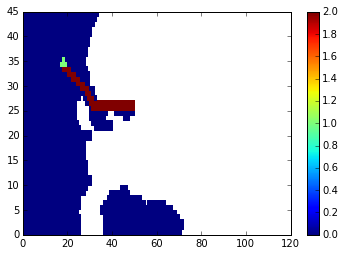

In [4]:
# read in new bathymetry
nc_filepath3 = '../../NEMO-forcing/grid/bathy_with_Fraser.nc'
bathy = nc.Dataset(nc_filepath3, 'r')
depth = bathy.variables['Bathymetry']
imin = 390; imax = 435; jmin = 285; jmax = 398
plt.pcolormesh(depth[imin:imax,jmin:jmax]-old_depth[imin:imax,jmin:jmax])
plt.colorbar()

In [5]:
floor = np.empty_like(depths)
ceil = np.empty_like(depths)
ceil[0] = 0.
floor[0] = 2*depths[0]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depths[k] -floor[k-1]

In [6]:
S = np.empty_like(old_salinity)
T = np.empty_like(old_temperature)
# for every cell with top of cell depth < bathymetry, use old TS, if old TS=0, find closest point and use that.
for k in range(40):
    print k
    for j in range(398):
        for i in range(898):
            if ceil[k] < depth[i,j]:
                if old_salinity[k,i,j] <> 0:
                    S[k,i,j] = old_salinity[k, i, j]
                    T[k,i,j] = old_temperature[k, i, j]
                else:
                    # closest neighbour thing
                    masked_array = np.ma.array(old_salinity[k], mask = old_salinity[k] == 0)
                    X, Y = tidetools.find_closest_model_point(lon[i,j], lat[i,j], lon, lat, masked_array)
                    S[k, i, j] = old_salinity[k, X, Y]
                    T[k, i, j] = old_temperature[k, X, Y]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [7]:
# build nc file
new_TS = nc.Dataset('TSforBlastFraser.nc', 'w')
nc_tools.init_dataset_attrs(
    new_TS, 
    title='Salinity Temperature Initial Conditions based on Nowcast May 10, 2015 for Blasted out Fraser', 
    notebook_name='Find TS for new Bathymetry', 
    nc_filepath='../../../nemo-forcing/initial_strat/TSforBlastFraser.nc',
    comment='Salinity and Temperature conditions from nowcast May 10, 2015 onto Blasted Fraser bathymetry')
new_TS.createDimension('y', 898)
new_TS.createDimension('x', 398)
new_TS.createDimension('deptht',size = len(depths))
new_TS.createDimension('time_counter', None)
nc_tools.show_dimensions(new_TS)
# variables
nav_lat = new_TS.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat = lat
nav_lon = new_TS.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon = lon
deptht = new_TS.createVariable('deptht', 'float32', ('deptht'))
deptht.long_name = 'Depth'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))
deptht = depths
time_counter = new_TS.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.units = 'seconds since 2015-05-10 0:00:00'
time_counter.long_name = 'Time axis'
vosaline = new_TS.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','y','x'))
vosaline.units = 'none'
vosaline.long_name = 'Practical Salinity'  
vosaline.coordinates = 'nav_lon nav_lat deptht time_counter'
vosaline.grid = 'SalishSea2, Blast Fraser'
vosaline[0] = S
votemper = new_TS.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','y','x'))
votemper.units = 'degC'
votemper.long_name = 'Temperature' 
votemper.coordinates = 'nav_lon nav_lat deptht time_counter'
votemper[0] = T
new_TS.history = """[2015-05-20] Created"""

file format: NETCDF4
Conventions: CF-1.6
title: Salinity Temperature Initial Conditions based on Nowcast May 10, 2015 for Blasted out Fraser
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/Find TS for new Bathymetry.ipynb
references: REQUIRED
history: [2015-05-20 18:21:07] Created netCDF4 zlib=True dataset.
comment: Salinity and Temperature conditions from nowcast May 10, 2015 onto Blasted Fraser bathymetry
<type 'netCDF4.Dimension'>: name = 'y', size = 898

<type 'netCDF4.Dimension'>: name = 'x', size = 398

<type 'netCDF4.Dimension'>: name = 'deptht', size = 40

<type 'netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0



(1, 40, 898, 398)


<matplotlib.colorbar.Colorbar instance at 0x7ff1cec2e998>

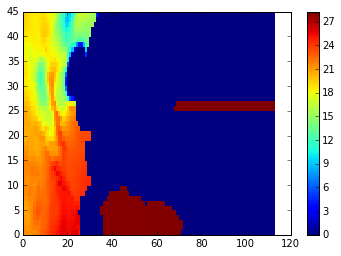

In [15]:
print votemper[:].shape
plt.pcolormesh(vosaline[0,3,imin:imax,jmin:jmax])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7ff1ceb13cb0>

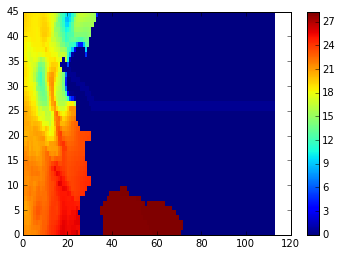

In [16]:
ik = 425; jk = 302; d = 0.5
vosaline[0,0:6,ik,jk+1] = d
vosaline[0,0:6,ik-1,jk:jk+3] = d
vosaline[0,0:6,ik-2,jk+1:jk+5] = d
vosaline[0,0:6,ik-3,jk+3:jk+7] = d
vosaline[0,0:6,ik-4,jk+5:jk+9] = d
vosaline[0,0:6,ik-5,jk+7:jk+11] = d
vosaline[0,0:6,ik-6,jk+9:jk+13] = d
vosaline[0,0:6,ik-7,jk+11:jk+14] = d
vosaline[0,0:6,ik-8,jk+12:jk+15] = d
vosaline[0,0:6,ik-9,jk+13:] = d
vosaline[0,0:6,ik-10,jk+14:] = d
plt.pcolormesh(vosaline[0,3,imin:imax,jmin:jmax])
plt.colorbar()

In [17]:
new_TS.close()